# Predicting mobile app user churn



## Introduction

This project was created when I was in a hackathon event which was held in Bangkok. The main objective is to find a way to increase daily active users(DAU) on mobile application. 

Here is a quick overview what the application can do.
- It is the application for fans to follow their favorite artists. They can see feed of artists which is retrieved from facebook and instagram. 


- Users are challenged by collecting exp and coins. They can use them for exchanging rewards like a concert ticket and an exclusive video for the top fans.


- Exp and coins will be given when 
  - Users participate in the feed such as LIKE or COMMENT
  - Users win missions by answering quizzes


## Data Explanation
Dataset is given in CSV format according to relational database. So we need to merge or join some dataframes to create a final useful dataset. Provided dataset can be briefly summarized into 4 categories below.

#### Dynamic data
- User activities

#### Static data
- User information
- Feed information
- Artist information
- Mission information


From the business objective, I've decided to use <b>churn prediction</b> which identifies and targets users who are likely to stop using application. These predictive capabilities lead to new insights into user behavior. Business users can then build new engagement strategies to the right customers.

Churn prediction usually depends on user activities or behavior. So we will primarily focus on dynamic data. 

Here is a data dictionary for user activities table. We will need to extract and create new features from this. Features need to be selected carefully as they need to be meaningful and having an influence on model. 

- userid	varchar(255)		
- action	varchar(255)		
- objecttype	varchar(255)		
- objectid	varchar(65535)		
- ads_on_page	varchar(255)	
- sponsorid	varchar(255)		
- aritstid	varchar(255)		
- time_stamp	timestamp		
- exp	int	
- coin	int	

After spending a lot of time to extract useful features, there are six features below 

In our case user activities are provided with only 25 days. we will use first week information  

- Total number of activities : Count number of activities group by each user
- Total exp : Sum total exp group by each user
- Total coins : Sum total coins group by each user
- Inactive days : Number of days from last active activity to end of the week
- Active days : Number of days that users have any activities
- Membership peiod (need extra info which is created time from user table)
- y :  y = 1 if user has any activities in the next week, 0 otherwise


#### The process can be divided into 4 steps below.

1. Data exploration : Determine null values, 
2. Data preprocessing : Create 6 features, check multicollinear
3. Modeling : Logistic regression
4. Evaluate and interpret model : F1 score, coefficient and odd ratios


## 1. Data Exploration

Import necessary packages

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Read two CSV files for further analysis. However, we need an 

In [2]:
#Import user activities information
userActivity = pd.read_csv('DataSource/application_txn.csv',usecols=["userid","objecttype","action","time_stamp2","exp","coin"])
userInformation = pd.read_csv('DataSource/user.csv',usecols=['userid','gender','birth_year','createdtm'])

#Merge between user activity and information table
userMerged = pd.merge(userActivity,userInformation, on='userid')
#Show size of dataframe and previewing some records
print(userMerged.shape)
userMerged.head(5)

(716814, 9)


,userid,action,objecttype,time_stamp2,exp,coin,gender,birth_year,createdtm
0,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 00:04:22.842,0,0,female,2529,2017-06-08 04:58:23.262
1,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 13:54:08.707,0,0,female,2529,2017-06-08 04:58:23.262
2,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 00:02:00.242,0,0,female,2529,2017-06-08 04:58:23.262
3,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 20:19:15.048,0,0,female,2529,2017-06-08 04:58:23.262
4,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 20:34:37.440,0,0,female,2529,2017-06-08 04:58:23.262


In [3]:
#Find a period of all activities
from datetime import datetime

userMerged['time_stamp2'] = pd.to_datetime(userMerged['time_stamp2'], format = '%Y-%m-%d %H:%M:%S.%f')

startDate = min(userMerged.time_stamp2)
endDate = max(userMerged.time_stamp2)
print("Start date :",startDate)
print("End date:", endDate)
print("Period:", (endDate-startDate).days+1, "days")


Start date : 2017-07-01 00:00:01.688000
End date: 2017-07-25 23:59:58.382000
Period: 25 days


In [4]:
#Exclude all activites related users who create their account after start date. Because their activites might not enough for training 
userMerged['createdtm'] = pd.to_datetime(userMerged['createdtm'], format = '%Y-%m-%d %H:%M:%S.%f')
userMerged = userMerged[userMerged["createdtm"] < startDate]

#Verify whether the latest account was created before the startDate
print("the latest account was created at:",max(userMerged.createdtm))

#Define timeline in this case we want to limit the activities within only 1 week (from 2017-07-01 - 2017-07-07)
endDate = datetime.strptime("2017-07-08 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')
firstWeekUserMerged = userMerged[userMerged['time_stamp2'] < endDate]
print("the most recent activity is :",max(firstWeekUserMerged.time_stamp2))

firstWeekUserMerged.shape


the latest account was created at: 2017-06-30 12:53:09.255000
the most recent activity is : 2017-07-07 23:59:50.638000


(193147, 9)

In [5]:
#find out which column has any missing values
firstWeekUserMerged.isnull().sum()

userid             0
action             0
objecttype     31024
time_stamp2        0
exp                0
coin               0
gender          2194
birth_year     17680
createdtm          0
dtype: int64

In [6]:
#Because gender and age of customer are static infomation which might not related to behavior, we exclude them out
firstWeekUserMerged = firstWeekUserMerged.drop(["gender","birth_year"], axis=1)
firstWeekUserMerged.isnull().sum()

userid             0
action             0
objecttype     31024
time_stamp2        0
exp                0
coin               0
createdtm          0
dtype: int64

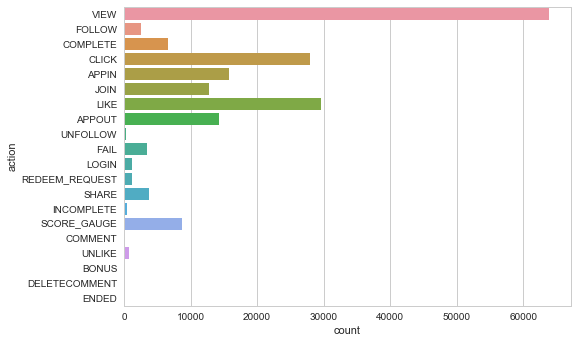

In [7]:
#Review histrogram of customer activities
sns.countplot(y="action",data=firstWeekUserMerged)
plt.show()

In [8]:
#Review number of users
numUsers = firstWeekUserMerged[['userid']].drop_duplicates().count()
print("The number of users is :",int(numUsers))

The number of users is : 1247


## 2. Data Preprocessing


### 2.1. Create total number of weekly activities  feature

In [9]:
X = firstWeekUserMerged.groupby('userid')["action"].count().reset_index(name="totalAct")
print(X.head(5))
print(X.shape)

                     userid  totalAct
0  592da01fe4b0a4ee112b84fb       311
1  592da02be4b09c162d708589       265
2  592da035e4b0a4ee112b8505       499
3  592da070e4b09c162d70859a       417
4  592da096e4b0a4ee112b852a       290
(1247, 2)


### 2.2. Create total accumulated exp and coin within one week feature

In [10]:
#APPIN = firstWeekUserMerged[firstWeekUserMerged["action"]=="APPIN"]
#APPOUT = firstWeekUserMerged[firstWeekUserMerged["action"]=="APPOUT"]

#totalAPPIN = APPIN.groupby("userid")["action"].count().reset_index(name="totalAPPIN")
#totalAPPOUT = APPOUT.groupby("userid")["action"].count().reset_index(name="totalAPPOUT")

#print(totalAPPIN.head(5))
#print(totalAPPOUT.head(5))
expAndCoinByUser = firstWeekUserMerged.groupby('userid')["exp","coin"].sum().reset_index()

print(expAndCoinByUser.head(5))
print(expAndCoinByUser.shape)

                     userid   exp  coin
0  592da01fe4b0a4ee112b84fb  3068  2012
1  592da02be4b09c162d708589  1513  1800
2  592da035e4b0a4ee112b8505  3285  4902
3  592da070e4b09c162d70859a     0     0
4  592da096e4b0a4ee112b852a   709  1000
(1247, 3)


In [11]:
#Merge into X
X = pd.merge(X, expAndCoinByUser, on="userid")
X.head(5)

,userid,totalAct,exp,coin
0,592da01fe4b0a4ee112b84fb,311,3068,2012
1,592da02be4b09c162d708589,265,1513,1800
2,592da035e4b0a4ee112b8505,499,3285,4902
3,592da070e4b09c162d70859a,417,0,0
4,592da096e4b0a4ee112b852a,290,709,1000


### 2.3 Create inactive period and membership period

- Inactive period = The period from the latest activity time to endDate
- membership period = The period from created account time to startDate

In order to create two features above, we need to find latest activity time by user and created time by user

#### 2.3.1 Latest activity time by user

In [12]:
#Change time_stamp2 column to be the most recent activity time by user
latestTimeByUser = firstWeekUserMerged.groupby('userid')['time_stamp2'].max().reset_index(name="recentTime")
latestTimeByUser.head(5)

,userid,recentTime
0,592da01fe4b0a4ee112b84fb,2017-07-06 12:06:45.295
1,592da02be4b09c162d708589,2017-07-06 12:08:26.112
2,592da035e4b0a4ee112b8505,2017-07-07 17:03:38.790
3,592da070e4b09c162d70859a,2017-07-06 12:14:26.016
4,592da096e4b0a4ee112b852a,2017-07-06 12:07:12.875


#### 2.3.2 Created account time

In [13]:
#Find only unique created account time by user
uniqueCreatedTimeByUser = firstWeekUserMerged[['userid','createdtm']].drop_duplicates()
uniqueCreatedTimeByUser.head(5)

,userid,createdtm
0,59391fbfe4b0a0f774fe022e,2017-06-08 04:58:23.262
340,592f8ddfe4b09c162d715525,2017-06-01 10:45:35.769
408,592e1c65e4b09c162d70ac5b,2017-05-31 08:29:09.357
797,5945552ee4b0db45c711c290,2017-06-17 11:13:34.423
1916,593e4481e4b06f7fcb9eabe4,2017-06-12 02:36:33.388


In [14]:
#Merge 2 dataframes above into X
X = pd.merge(X, latestTimeByUser, on="userid")
X = pd.merge(X, uniqueCreatedTimeByUser , on ="userid")
X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438


#### 2.3.3. Create inactive and membership period features

In [15]:
#It is the period between the time last activity took place and end date
X["inactivePeriod"] = endDate - X['recentTime']
#Convert to number of days
X["inactivePeriod"] = X.inactivePeriod.dt.days

#Create new feature of the membership period from the registration date until start date
X["memberPeriod"] = startDate - X["createdtm"]
#Convert to number of days
X["memberPeriod"] = X.memberPeriod.dt.days

X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31


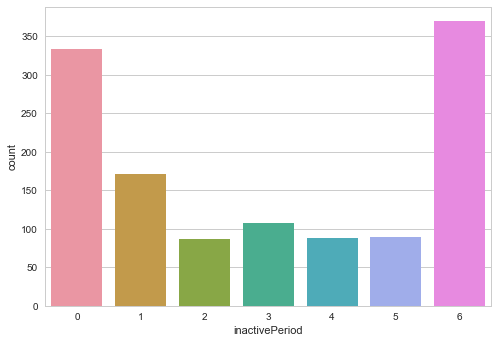

In [16]:
sns.countplot(x="inactivePeriod",data=X)
plt.show()

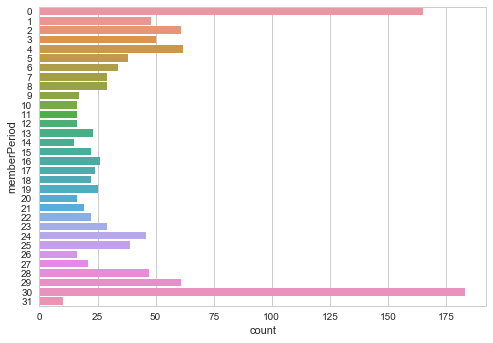

In [17]:
sns.countplot(y="memberPeriod",data=X)
plt.show()

### 2.4. Create activeDay feature
activeDay represents how often users use this application in one week

In [18]:
#Convert time_stamp2 to date
firstWeekUserMerged["day_time_stamp2"] = firstWeekUserMerged.time_stamp2.dt.day

#Count how often users use this application in one week

#Extract the number of day by users
activityByUserByday = firstWeekUserMerged.groupby('userid')["day_time_stamp2"].value_counts().index.tolist()
activityByUserByday = pd.DataFrame(activityByUserByday,columns=["userid","activeDay"])
#activityByUserByday.head(10)

In [19]:
#Accumulate number of day by user
activityByUserByday = activityByUserByday.groupby('userid')["activeDay"].count().reset_index()
activityByUserByday.head(10)

,userid,activeDay
0,592da01fe4b0a4ee112b84fb,5
1,592da02be4b09c162d708589,5
2,592da035e4b0a4ee112b8505,7
3,592da070e4b09c162d70859a,5
4,592da096e4b0a4ee112b852a,5
5,592da0bae4b0a4ee112b8545,6
6,592da122e4b09c162d708602,7
7,592da13ce4b09c162d70862a,3
8,592da3a2e4b0a4ee112b8618,4
9,592da3a3e4b09c162d708691,6


In [20]:
maxActiveDay = max(activityByUserByday["activeDay"])
print("\nThe highest number of active day is :",maxActiveDay,"days")

numberOfUser = activityByUserByday[activityByUserByday["activeDay"]==maxActiveDay].userid.count()
print("There are",numberOfUser,"users who keep playing the mobile application for", maxActiveDay,"days")

#Merge activeDay feature into training data
X = pd.merge(X, activityByUserByday[['userid','activeDay']] , on ="userid")


The highest number of active day is : 7 days
There are 100 users who keep playing the mobile application for 7 days


In [21]:

#activityDummies = pd.get_dummies(firstWeekUserMerged, columns =['action', 'objecttype'])
#activityDummies.columns

#accumulate the number of activities by user
#activityByUser = activityDummies.groupby('userid')[activityDummies.columns].sum().reset_index()
#activityByUser = activityByUser.drop(["exp","coin"], axis=1)
#activityByUser = activityByUser[["userid","action_APPIN","action_APPOUT"]]

#activityByUser.head(5)

#X = pd.merge(X, activityByUser , on ="userid")

In [22]:
X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod,activeDay
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31,5
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31,5
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31,7
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31,5
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31,5


### 2.5. Label dataset

- Y = 1 : When users don't have any activities in the next week
- Y = 0 : When users have at least one activity in the next week




the first activity is : 2017-07-08 00:00:00.080000
the most recent activity is : 2017-07-14 23:59:45.156000
                     userid  totalAct   exp  coin              recentTime  \
0  592da01fe4b0a4ee112b84fb       311  3068  2012 2017-07-06 12:06:45.295   
1  592da02be4b09c162d708589       265  1513  1800 2017-07-06 12:08:26.112   
2  592da035e4b0a4ee112b8505       499  3285  4902 2017-07-07 17:03:38.790   
3  592da070e4b09c162d70859a       417     0     0 2017-07-06 12:14:26.016   
4  592da096e4b0a4ee112b852a       290   709  1000 2017-07-06 12:07:12.875   

                createdtm  inactivePeriod  memberPeriod  activeDay  
0 2017-05-30 11:38:55.764               1            31          5  
1 2017-05-30 11:39:07.470               1            31          5  
2 2017-05-30 11:39:17.917               0            31          7  
3 2017-05-30 11:40:16.498               1            31          5  
4 2017-05-30 11:40:54.438               1            31          5  
               

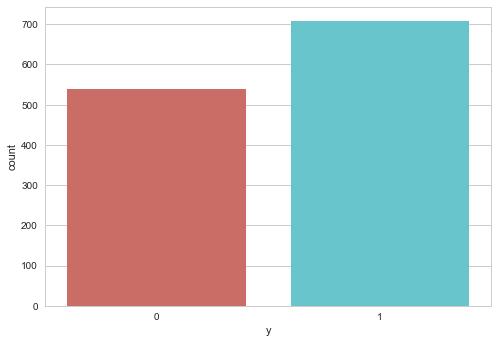

In [23]:
#Define Y = 0 when activeDay = MaxActiveDay (These users have new activites everyday). Otherwise Y = 1 (Churn)
#X['y'] = np.where(X["activeDay"]==maxActiveDay, 0 , 1)


#Define start and end date for next week
nextStartDate = datetime.strptime("2017-07-08 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')
nextEndDate = datetime.strptime("2017-07-15 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')

#Filter activity within nextweek peiod from predefined date above
nextWeekUserMerged = userMerged.loc[(userMerged['time_stamp2'] >= nextStartDate) & (userMerged['time_stamp2'] < nextEndDate)]
print("the first activity is :",min(nextWeekUserMerged.time_stamp2))
print("the most recent activity is :",max(nextWeekUserMerged.time_stamp2))

#Get only user list within next week period
nextWeekUserList = nextWeekUserMerged[["userid"]].drop_duplicates()
nextWeekUserList = nextWeekUserList["userid"].tolist()
#nextWeekUserList.head(5)
print(X.head(5))

X['y'] = np.where(X["userid"].isin(nextWeekUserList),0 , 1)
print(X.head(5))


#Determine histrogram of Y
sns.countplot(x="y",data=X,palette='hls')
plt.show()

In [24]:
X.head()

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod,activeDay,y
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31,5,1
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31,5,0
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31,7,0
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31,5,0
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31,5,0


In [25]:
#Last verification before running model

In [26]:
#Remove unnesscary timestamp as we have already created inactive and active feature
X.drop(["recentTime","createdtm"], axis=1, inplace=True)
X.isnull().sum()


userid            0
totalAct          0
coin              0
inactivePeriod    0
memberPeriod      0
activeDay         0
y                 0
dtype: int64

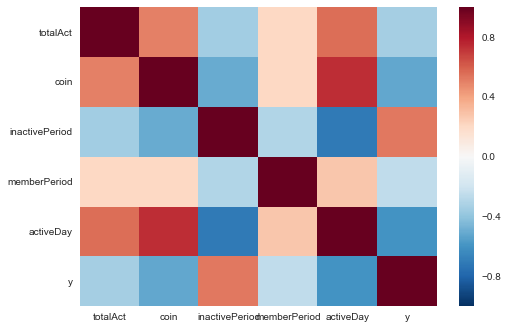

,userid,totalAct,coin,inactivePeriod,memberPeriod,activeDay,y
0,592da01fe4b0a4ee112b84fb,311,2012,1,31,5,1
1,592da02be4b09c162d708589,265,1800,1,31,5,0
2,592da035e4b0a4ee112b8505,499,4902,0,31,7,0
3,592da070e4b09c162d70859a,417,0,1,31,5,0
4,592da096e4b0a4ee112b852a,290,1000,1,31,5,0


In [27]:
sns.heatmap(X.corr())
plt.show()

X.head(5)

In [28]:
X.head(5)

,userid,totalAct,coin,inactivePeriod,memberPeriod,activeDay,y
0,592da01fe4b0a4ee112b84fb,311,2012,1,31,5,1
1,592da02be4b09c162d708589,265,1800,1,31,5,0
2,592da035e4b0a4ee112b8505,499,4902,0,31,7,0
3,592da070e4b09c162d70859a,417,0,1,31,5,0
4,592da096e4b0a4ee112b852a,290,1000,1,31,5,0


## 1. Finding current daily active user(DAU) from existing dataset

In [29]:
print(X.shape)
y = X.iloc[:,-1]
X = X.iloc[:,1:-1]
print(X.shape)

X.head(5)

(1247, 7)
(1247, 5)


,totalAct,coin,inactivePeriod,memberPeriod,activeDay
0,311,2012,1,31,5
1,265,1800,1,31,5
2,499,4902,0,31,7
3,417,0,1,31,5
4,290,1000,1,31,5


In [30]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#print("Feature space holds",X.shape[0],"observations and",X.shape[1],"features")
#print("Unique target labels:", np.unique(y))

In [31]:
#pd.DataFrame(X)


## 2. Comparing between number of activities and action of DAU

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(935, 5)

## Logistic Regression


In [33]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

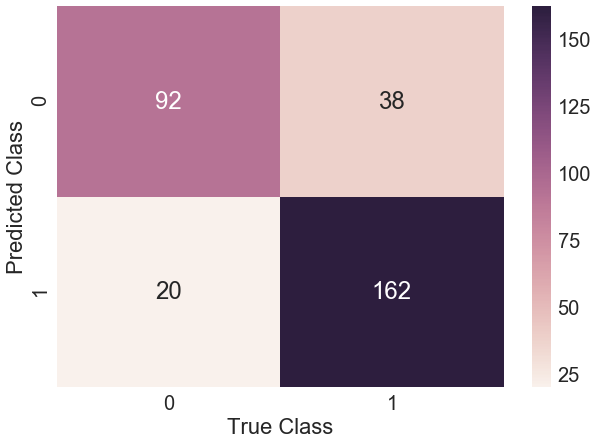

In [34]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=2)#for label size

plt.figure(figsize = (10,7))
confusion_plot = sns.heatmap(confusion_matrix, annot=True,fmt='g')

confusion_plot.set(xlabel='True Class', ylabel='Predicted Class')

plt.show()


In [35]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.82      0.71      0.76       130
          1       0.81      0.89      0.85       182

avg / total       0.81      0.81      0.81       312



In [37]:
for idx, col_name in enumerate(X_train.columns):
    print("The odd ratios for {} is {}".format(col_name, np.exp(classifier.coef_[0][idx])))

The odd ratios for totalAct is 0.9960734794520887
The odd ratios for coin is 0.999793657905279
The odd ratios for inactivePeriod is 1.2377312458460585
The odd ratios for memberPeriod is 0.9857717459374266
The odd ratios for activeDay is 0.7624453170880672


In [38]:
pred_prob = classifier.predict_proba(X_test)
pred_prob = pd.DataFrame(classifier.predict_proba(X_test), columns=classifier.classes_)
#pred_churn = pred_prob[:,1]
#is_churn = y == 1
pred_prob.head(5)

,0,1
0,0.138612,0.861388
1,0.317871,0.682129
2,0.837345,0.162655
3,0.342424,0.657576
4,0.975658,0.024342


In [46]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
logit = sm.Logit(y_train, X_train)
result = logit.fit()



Optimization terminated successfully.
         Current function value: 0.465433
         Iterations 8


In [47]:
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  935
Model:                          Logit   Df Residuals:                      930
Method:                           MLE   Df Model:                            4
Date:                Sun, 29 Oct 2017   Pseudo R-squ.:                  0.3208
Time:                        19:09:16   Log-Likelihood:                -435.18
converged:                       True   LL-Null:                       -640.75
                                        LLR p-value:                 1.086e-87
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
totalAct          -0.0051      0.002     -3.381      0.001      -0.008      -0.002
coin              -0.0002    8.4e-05     -2.424      0.015      -0.000    -3.9e-05
inactivePeriod     0.3468      0.027     12.642      0.000       0.293       0.401
memberPeriod      -0.0022      0.007     -0.327      0.743      -0.016       0.011
activeDay         -0.0189      0.071     -0.266      0.790      -0.158       0.120
==================================================================================
"""

In [50]:
for idx, col_name in enumerate(X_train.columns):
    print("The odd ratios for {} is {}".format(col_name, classifier.coef_[0][idx]))

The odd ratios for totalAct is -0.003934249568457314
The odd ratios for coin is -0.00020636338617995432
The odd ratios for inactivePeriod is 0.21328006333370558
The odd ratios for memberPeriod is -0.014330446171071388
The odd ratios for activeDay is -0.2712244883665732


In [48]:
result.conf_int()

,0,1
totalAct,-0.008057,-0.002143
coin,-0.000368,-0.000039
inactivePeriod,0.293043,0.400577
memberPeriod,-0.015639,0.011161
activeDay,-0.158311,0.120466


In [49]:
np.exp(result.params)

totalAct          0.994913
coin              0.999796
inactivePeriod    1.414548
memberPeriod      0.997764
activeDay         0.981255
dtype: float64